# Customer Churn Prediction using Random Forest
---

#### Objective
To predict whether a customer will churn (leave) or stay based on demographic, account, and service-related features using a Random Forest Classifier.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Shows plots in Jupyter notebook
%matplotlib inline
# Setting visualization style
sns.set(color_codes=True)

Data Source: [Kaggle Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

In [2]:
# Loading the dataset into a dataframe
df=pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
# Displaying the first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Checking the shape of the dataset
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 7043 rows and 21 columns.


In [5]:
# Getting further information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Checking for missing values
df.isnull().sum().any()

False

In [7]:
# Checking the class distribution of target variable
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [8]:
# Checking the percentage of each target class
df['Churn'].value_counts(normalize=True) * 100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

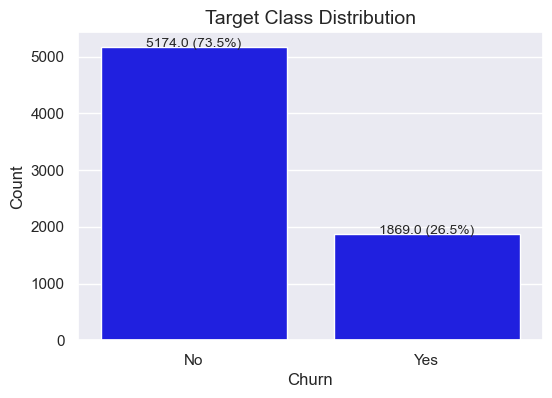

In [9]:
# Plotting the distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Churn', data=df, color='blue')
plt.title('Target Class Distribution', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Count')

# Adding count & percentage labels above bars
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / len(df)
    ax.text(p.get_x() + p.get_width()/2., height + 2,
            f'{height} ({percentage:.1f}%)',
            ha='center', fontsize=10)
plt.show()

The dataset is imbalanced: 73.46% of customers did not churn, and 26.54% did. This imbalance may cause the model to favor the majority class (non-churners) during training, leading to biased predictions.

In [10]:
#Data Preprocessing
# Converting TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Encode target variable
label_encoder = LabelEncoder()
df['Churn'] = label_encoder.fit_transform(df['Churn'])  # Yes=1, No=0

# Get list of categorical columns (excluding the customerID)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

# One-hot encode categorical variables only
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [11]:
# Getting a summary of the dataset using descriptive statistics
print("\nSummary of the numerical columns:")
df.describe().T


Summary of the numerical columns:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.000,1.0000,1.00


In [12]:
# Defining the independent and target Variables
X = df.drop(columns=['customerID', 'Churn'], axis=1)
y = df['Churn']

In [13]:
# Confirming the shape of the feature matrix
X.shape

(7043, 30)

In [14]:
# Confirming the shape of the target vector
y.shape

(7043,)

In [15]:
# Splitting the data into training (80%) and testing (20%) sets while maintaining balance in the target variable
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Standardizing feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Initializing and training the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced',max_depth=None)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [18]:
# Making predictions
y_pred = model.predict(X_test)

Accuracy: 0.7877927608232789

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



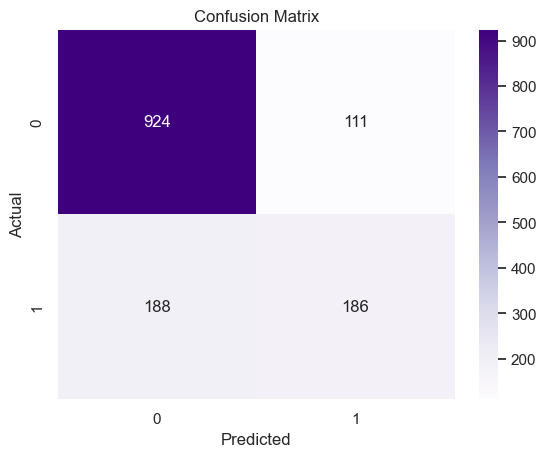

In [19]:
# Evaluating Model's Performance
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Interpretation

The Random Forest Classifier model demonstrates strong performance in correctly identifying customers who did not churn (majority class), achieving high precision and recall for class 0. However, performance for the churned customers (minority class) remains moderate, indicating that the model still misses some churn cases. Overall, the model is reasonably balanced, correctly classifying around 79% of the test data. The use of "class_weight='balanced'" helped the model pay more attention to the minority class and improve its ability to detect churners. Future improvements could include experimenting with SMOTE oversampling, hyperparameter tuning, or feature selection to further boost recall for churn prediction.

    index                     features  importance
25     10  InternetService_Fiber optic    0.038299
26     25            Contract_Two year    0.060063
27      2               MonthlyCharges    0.155002
28      1                       tenure    0.166684
29      3                 TotalCharges    0.173802


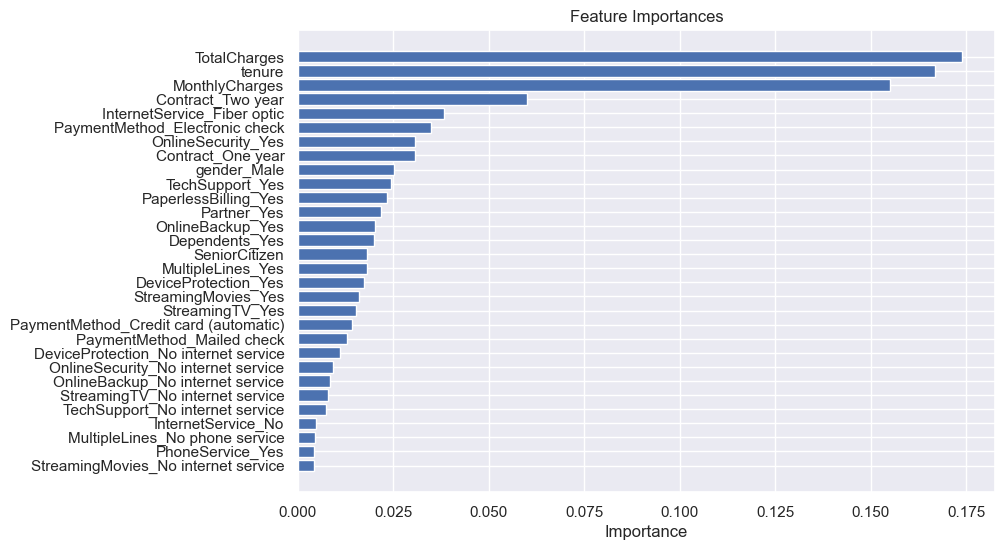

In [20]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()
print(feature_importances.tail())

plt.figure(figsize=(9, 6))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

The feature importance result identifies TotalCharges, Tenure, and MonthlyCharges as the key drivers influencing customer churn and having the highest impact on the model's churn prediction. Customers with higher total charges or shorter tenure are more likely to churn. Overall, these insights provide valuable information for developing targeted retention strategies.